<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/pytorch/UNet_Seg_VOC2012_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNet, VOC Segmentation 2012

元論文 : U-Net https://arxiv.org/abs/1505.04597 (2015)



In [0]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [0]:
import os
import argparse
from pprint import pprint
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from easydict import EasyDict

import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torchvision import transforms


#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
            'dinigtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'void'] # list, dict('label' : '[R, G, B]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 128
cfg.INPUT_WIDTH = 128
cfg.INPUT_CHANNEL = 3
cfg.INPUT_CMAP = 'gray'

cfg.OUTPUT_HEIGHT = 128
cfg.OUTPUT_WIDTH = 128
cfg.OUTPUT_CHANNEL = cfg.CLASS_NUM
cfg.OUTPUT_CMAP = 'jet' # pyplot cmap

cfg.G_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'UNet'
cfg.TRAIN.MODEL_SAVE_PATH = 'models/' + cfg.PREFIX + '_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 1_000
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 16
cfg.TRAIN.OPTIMIZER = torch.optim.SGD
cfg.TRAIN.LEARNING_PARAMS = {'lr' : 0.01, 'momentum' : 0.9}#{'lr' : 0.01, 'betas' : (0.5, 0.9)}


cfg.TRAIN.DATA_PATH = 'data/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# pix2pix  config
#---
cfg.PIX2PIX_LAMBDA = 1


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_PATH = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = 'data/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 100 # None, int
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['background',
                 'aeroplane',
                 'bicycle',
                 'bird',
                 'boat',
                 'bottle',
                 'bus',
                 'car',
                 'cat',
                 'chair',
                 'cow',
                 'dinigtable',
                 'dog',
                 'horse',
                 'motorbike',
                 'person',
                 'pottedplant',
                 'sheep',
                 'sofa',
                 'train',
                 'tvmonitor',
                 'void'],
 'CLASS_NUM': 22,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CHANNEL': 3,
 'INPUT_CMAP': 'gray',
 'INPUT_HEIGHT': 128,
 'INPUT_WIDTH': 128,
 'OUTPUT_CHANNEL': 22,
 'OUTPUT_CMAP': 'jet',
 'OUTPUT_HEIGHT': 128,
 'OUTPUT_WIDTH': 128,
 'PIX2PIX_LAMBDA': 1,
 'PREFIX': 'UNet',
 'TEST': {'DATA_PATH': 'data/',
          'ITERATION': 2,
          

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.reshape(x.size()[0], -1)

    
class Encoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name, stack_num=2):
        super(Encoder_block, self).__init__()
        _module = OrderedDict()
        for i in range(stack_num):
            f = dim1 if i == 0 else dim2
            _module['{}_stack_{}_conv'.format(name, i  + 1)] = torch.nn.Conv2d(f, dim2, kernel_size=3, padding=1, stride=1)
            _module['{}_stack_{}_act'.format(name, i + 1)] = torch.nn.ReLU()
            _module['{}_stack_{}_bn'.format(name, i + 1)] = torch.nn.BatchNorm2d(dim2)
            
        self.module = torch.nn.Sequential(_module)

    def forward(self, x):
        return self.module(x)

class Decoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name):
        super(Decoder_block, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            '{}_transConv'.format(name) : torch.nn.ConvTranspose2d(dim1, dim2, kernel_size=2, stride=2),
            '{}_bn'.format(name) : torch.nn.BatchNorm2d(dim2)
        }))

    def forward(self, x):
        return self.module(x)

    
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        dim = cfg.G_DIM
        
        self.encoders = torch.nn.ModuleList([
            Encoder_block(cfg.INPUT_CHANNEL, dim, name='encoder_1'), 
            Encoder_block(dim, dim * 2, name='encoder_2'),
            Encoder_block(dim * 2, dim * 4, name='encoder_3'),
            Encoder_block(dim * 4, dim * 8, name='encoder_4'),
            Encoder_block(dim * 8, dim * 16, name='encoder_5'),
            #Encoder_block(dim * 16, dim * 16, name='G_encoder_6'),
        ])
        
        self.decoders = torch.nn.ModuleList([
            #Encoder_block(dim * 16, dim * 16, name='G_decoder_5'),
            Encoder_block(dim * 16, dim * 8, name='decoder_4'),
            Encoder_block(dim * 16, dim * 4, name='decoder_3'),
            Encoder_block(dim * 8, dim * 2, name='decoder_2'),
            Encoder_block(dim * 4, dim, name='decoder_1'),
        ])
            
        self.out = torch.nn.Sequential(OrderedDict({
            'G_out' : torch.nn.Conv2d(dim, cfg.OUTPUT_CHANNEL, kernel_size=1, padding=0, stride=1),
            #'G_out_act' : torch.nn.Softmax(dim=1)
        }))

        
    def forward(self, x):
        outputs = []
        # encoder
        for encoder in self.encoders[:-1]:
            x = encoder(x)
            outputs.append(x)
            x = F.max_pool2d(x, 2, stride=2, padding=0)
        
        x = self.encoders[-1](x)
        
        # decoder
        for i, decoder in enumerate(self.decoders[:-1]):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = torch.cat([x, outputs[ - i - 1]], dim=1)
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.decoders[-1](x)
        return self.out(x)


## Utility

In [0]:
class BatchGenerator():
    def __init__(self, data_size, batch_size, shuffle=True):
        self.data_size = data_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mbi = 0 # index for iteration
        self.inds = np.arange(data_size)
        if shuffle:
            np.random.shuffle(self.inds)

    def __call__(self):
        if self.mbi + self.batch_size >= self.data_size:
            inds = self.inds[self.mbi:]
            if self.shuffle:
                np.random.shuffle(self.inds)
            last_i = self.batch_size - self.data_size + self.mbi
            inds = np.hstack((inds, self.inds[ : last_i]))
            self.mbi = last_i
        else:
            inds = self.inds[self.mbi : self.mbi + self.batch_size]
            self.mbi += self.batch_size
        return inds

def result_show(Xs, ys, ts, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    Xs = (Xs.detach().cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1)
    ys = ys.detach().cpu().numpy().astype(np.uint8)
    ts = ts.detach().cpu().numpy().astype(np.uint8)

    show_max = min(cfg.TEST.MINIBATCH, len(Xs))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show input
        plt.subplot(3, show_max, i + 1)
        plt.imshow(Xs[i], cmap=cmap_in)
        plt.axis('off')
        plt.title('In {}'.format(i + 1))
        
        # show output
        plt.subplot(3, show_max, i + 1 + show_max)
        plt.imshow(ys[i], cmap=cmap_out, vmax=cfg.CLASS_NUM)
        plt.axis('off')
        plt.title('pred {}'.format(i + 1))

        # show ts
        plt.subplot(3, show_max, i + 1 + show_max * 2)
        plt.imshow(ts[i], cmap=cmap_out, vmax=cfg.CLASS_NUM)
        plt.axis('off')
        plt.title('ts {}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

#---
# torchvision dataset transform
#---
from PIL import Image

class Seg2Index(object):
    def __init__(self, border=False):
        self.border = border # contain border

    def __call__(self, x):
        x = np.array(x.convert('P')) # convert image > index
        if not self.border:
            x[x == 255] = 0
        return Image.fromarray(x)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToTensorKeepValue(object):
    def __call__(self, x):
        return torch.tensor(np.array(x), dtype=torch.long)

    def __repr__(self):
        return self.__class__.__name__ + '()'


transform = transforms.Compose([
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    Seg2Index(),
    transforms.Resize((cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH)),
    ToTensorKeepValue()
])

## Train

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 32, 128, 128]           9,248
              ReLU-5         [-1, 32, 128, 128]               0
       BatchNorm2d-6         [-1, 32, 128, 128]              64
     Encoder_block-7         [-1, 32, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
              ReLU-9           [-1, 64, 64, 64]               0
      BatchNorm2d-10           [-1, 64, 64, 64]             128
           Conv2d-11           [-1, 64, 64, 64]          36,928
             ReLU-12           [-1, 64, 64, 64]               0
      BatchNorm2d-13           [-1, 64, 64, 64]             128
    Encoder_block-14           [-1, 64,

train data = 1464
training start
Iter:50, Loss:1.1466, Accuracy:0.7890
Iter:100, Loss:1.1766, Accuracy:0.7459
Iter:150, Loss:1.0629, Accuracy:0.7723
Iter:200, Loss:1.2488, Accuracy:0.7030
Iter:250, Loss:1.1893, Accuracy:0.7266
Iter:300, Loss:1.0861, Accuracy:0.7262
Iter:350, Loss:1.2600, Accuracy:0.6909
Iter:400, Loss:1.0191, Accuracy:0.7554
Iter:450, Loss:1.3210, Accuracy:0.6532
Iter:500, Loss:1.3213, Accuracy:0.6776
result was saved to >> result/UNet_result_iter500.jpg


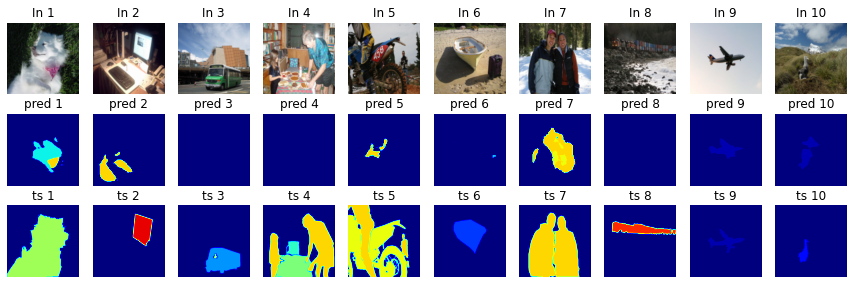

Iter:550, Loss:0.9093, Accuracy:0.7455
Iter:600, Loss:1.0030, Accuracy:0.7585
Iter:650, Loss:1.3747, Accuracy:0.6690
Iter:700, Loss:0.8185, Accuracy:0.7841
Iter:750, Loss:1.1234, Accuracy:0.7088
Iter:800, Loss:0.7104, Accuracy:0.8199
Iter:850, Loss:1.1543, Accuracy:0.6697
Iter:900, Loss:0.8668, Accuracy:0.7580
Iter:950, Loss:1.2659, Accuracy:0.6834
Iter:1000, Loss:1.2054, Accuracy:0.6829
save  >> models/UNet_iter1000.pt
result was saved to >> result/UNet_result_iter1000.jpg


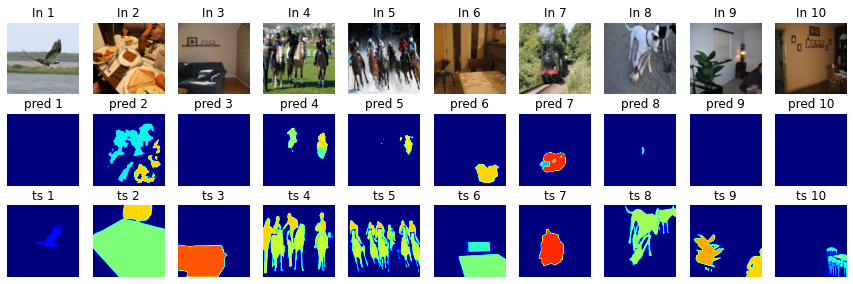

Iter:1050, Loss:0.8591, Accuracy:0.8024
Iter:1100, Loss:1.0047, Accuracy:0.7285
Iter:1150, Loss:1.1426, Accuracy:0.6991
Iter:1200, Loss:0.7625, Accuracy:0.7991
Iter:1250, Loss:0.7157, Accuracy:0.8020
Iter:1300, Loss:0.8402, Accuracy:0.7883
Iter:1350, Loss:0.8062, Accuracy:0.7630
Iter:1400, Loss:0.8549, Accuracy:0.7534
Iter:1450, Loss:0.9187, Accuracy:0.7706
Iter:1500, Loss:0.9198, Accuracy:0.7389
result was saved to >> result/UNet_result_iter1500.jpg


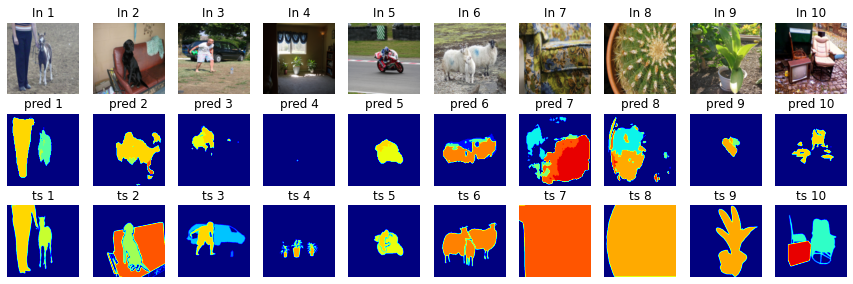

Iter:1550, Loss:0.6856, Accuracy:0.8190
Iter:1600, Loss:0.6993, Accuracy:0.8006
Iter:1650, Loss:0.5723, Accuracy:0.8565
Iter:1700, Loss:0.5723, Accuracy:0.8505
Iter:1750, Loss:0.5653, Accuracy:0.8405
Iter:1800, Loss:0.6192, Accuracy:0.8385
Iter:1850, Loss:0.6704, Accuracy:0.8092
Iter:1900, Loss:0.5084, Accuracy:0.8735
Iter:1950, Loss:0.5479, Accuracy:0.8502
Iter:2000, Loss:0.4233, Accuracy:0.8746
save  >> models/UNet_iter2000.pt
result was saved to >> result/UNet_result_iter2000.jpg


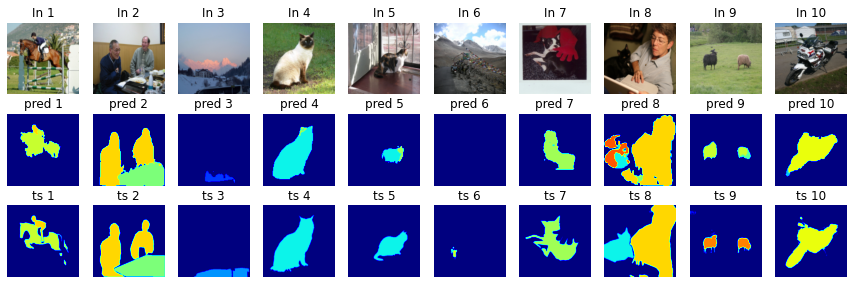

Iter:2050, Loss:0.3855, Accuracy:0.8961
Iter:2100, Loss:0.4572, Accuracy:0.8769
Iter:2150, Loss:0.4830, Accuracy:0.8665
Iter:2200, Loss:0.4735, Accuracy:0.8801
Iter:2250, Loss:0.5619, Accuracy:0.8559
Iter:2300, Loss:0.4231, Accuracy:0.8903
Iter:2350, Loss:0.3364, Accuracy:0.9246
Iter:2400, Loss:0.6391, Accuracy:0.8291
Iter:2450, Loss:0.3424, Accuracy:0.9214
Iter:2500, Loss:0.6616, Accuracy:0.8122
result was saved to >> result/UNet_result_iter2500.jpg


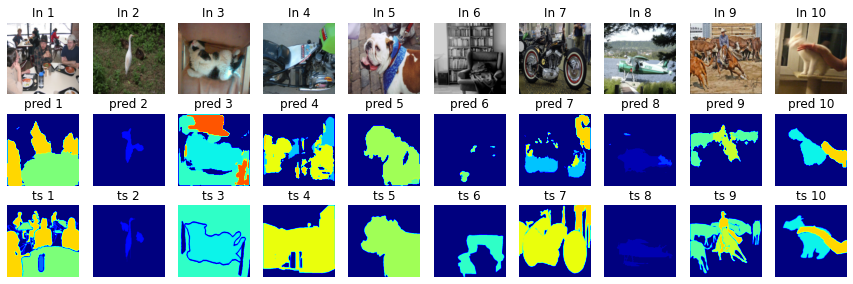

Iter:2550, Loss:0.4881, Accuracy:0.8677
Iter:2600, Loss:0.3818, Accuracy:0.9041
Iter:2650, Loss:0.5562, Accuracy:0.8522
Iter:2700, Loss:0.3639, Accuracy:0.9135
Iter:2750, Loss:0.3289, Accuracy:0.9226
Iter:2800, Loss:0.2431, Accuracy:0.9481
Iter:2850, Loss:0.2859, Accuracy:0.9353
Iter:2900, Loss:0.2611, Accuracy:0.9369
Iter:2950, Loss:0.2748, Accuracy:0.9354
Iter:3000, Loss:0.2885, Accuracy:0.9308
save  >> models/UNet_iter3000.pt
result was saved to >> result/UNet_result_iter3000.jpg


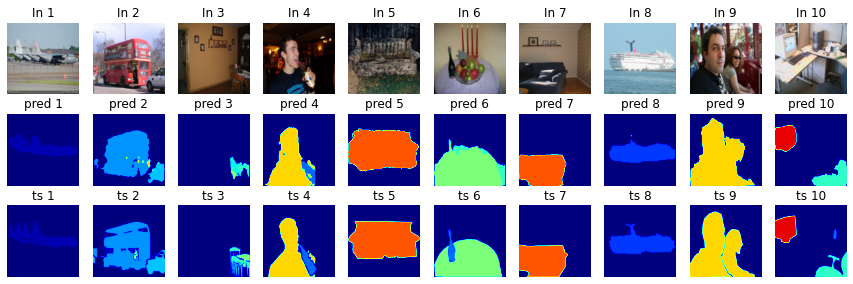

Iter:3050, Loss:0.2741, Accuracy:0.9344
Iter:3100, Loss:0.4891, Accuracy:0.8762
Iter:3150, Loss:0.3529, Accuracy:0.9134
Iter:3200, Loss:0.2647, Accuracy:0.9404
Iter:3250, Loss:0.2156, Accuracy:0.9493
Iter:3300, Loss:0.2333, Accuracy:0.9437
Iter:3350, Loss:0.2110, Accuracy:0.9516
Iter:3400, Loss:0.2460, Accuracy:0.9411
Iter:3450, Loss:0.2262, Accuracy:0.9492
Iter:3500, Loss:0.2709, Accuracy:0.9311
result was saved to >> result/UNet_result_iter3500.jpg


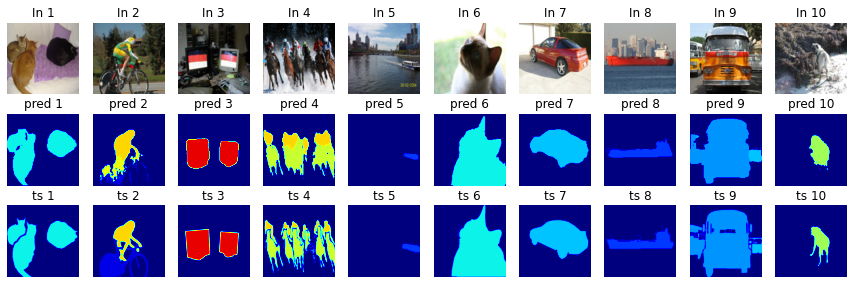

Iter:3550, Loss:0.1933, Accuracy:0.9527
Iter:3600, Loss:0.3124, Accuracy:0.9247
Iter:3650, Loss:0.2403, Accuracy:0.9418
Iter:3700, Loss:0.2729, Accuracy:0.9337
Iter:3750, Loss:0.2618, Accuracy:0.9345
Iter:3800, Loss:0.2115, Accuracy:0.9501
Iter:3850, Loss:0.2282, Accuracy:0.9427
Iter:3900, Loss:0.1857, Accuracy:0.9558
Iter:3950, Loss:0.2465, Accuracy:0.9409
Iter:4000, Loss:0.2085, Accuracy:0.9490
save  >> models/UNet_iter4000.pt
result was saved to >> result/UNet_result_iter4000.jpg


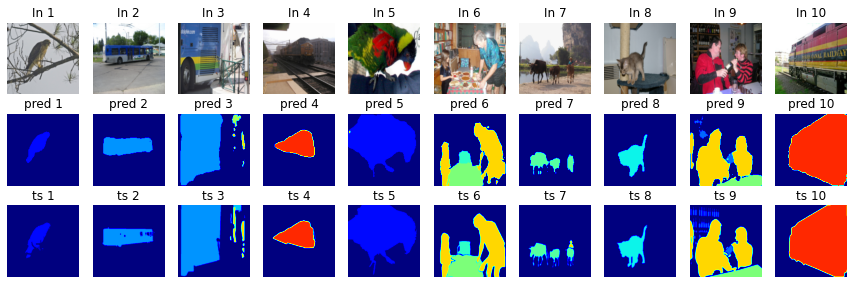

Iter:4050, Loss:0.2018, Accuracy:0.9493
Iter:4100, Loss:0.1635, Accuracy:0.9589
Iter:4150, Loss:0.1753, Accuracy:0.9580
Iter:4200, Loss:0.1885, Accuracy:0.9523
Iter:4250, Loss:0.2037, Accuracy:0.9515
Iter:4300, Loss:0.1997, Accuracy:0.9488
Iter:4350, Loss:0.2216, Accuracy:0.9464
Iter:4400, Loss:0.1647, Accuracy:0.9591
Iter:4450, Loss:0.1814, Accuracy:0.9548
Iter:4500, Loss:0.1785, Accuracy:0.9541
result was saved to >> result/UNet_result_iter4500.jpg


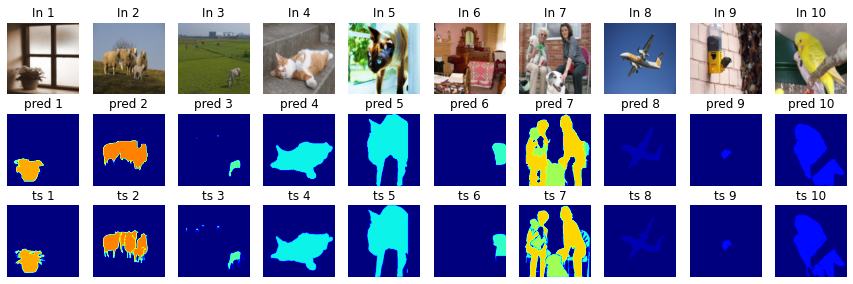

Iter:4550, Loss:0.2331, Accuracy:0.9425
Iter:4600, Loss:0.2529, Accuracy:0.9365
Iter:4650, Loss:0.1419, Accuracy:0.9640
Iter:4700, Loss:0.2753, Accuracy:0.9288
Iter:4750, Loss:0.2532, Accuracy:0.9347
Iter:4800, Loss:0.2030, Accuracy:0.9453
Iter:4850, Loss:0.1493, Accuracy:0.9618
Iter:4900, Loss:0.1767, Accuracy:0.9551
Iter:4950, Loss:0.2175, Accuracy:0.9440
Iter:5000, Loss:0.1625, Accuracy:0.9587
save  >> models/UNet_iter5000.pt
result was saved to >> result/UNet_result_iter5000.jpg


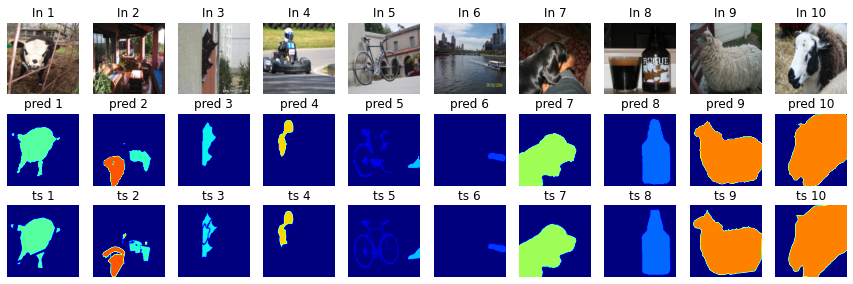

Iter:5050, Loss:0.1447, Accuracy:0.9618
Iter:5100, Loss:0.1775, Accuracy:0.9524
Iter:5150, Loss:0.1645, Accuracy:0.9577
Iter:5200, Loss:0.1672, Accuracy:0.9572
Iter:5250, Loss:0.1663, Accuracy:0.9551
Iter:5300, Loss:0.1582, Accuracy:0.9565
Iter:5350, Loss:0.3032, Accuracy:0.9245
Iter:5400, Loss:0.2053, Accuracy:0.9464
Iter:5450, Loss:0.1496, Accuracy:0.9602
Iter:5500, Loss:0.1302, Accuracy:0.9643
result was saved to >> result/UNet_result_iter5500.jpg


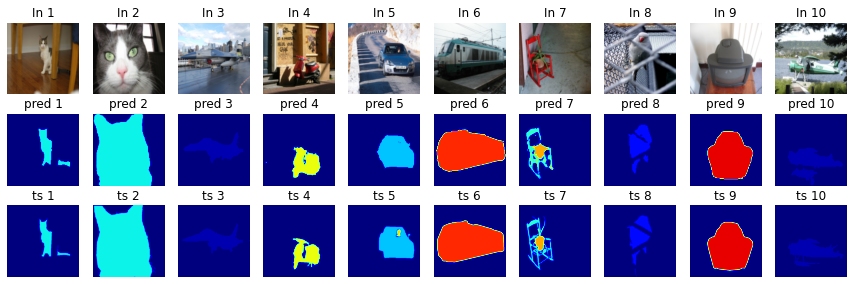

Iter:5550, Loss:0.2096, Accuracy:0.9461
Iter:5600, Loss:0.0987, Accuracy:0.9733
Iter:5650, Loss:0.1256, Accuracy:0.9651
Iter:5700, Loss:0.1758, Accuracy:0.9535
Iter:5750, Loss:0.1746, Accuracy:0.9537
Iter:5800, Loss:0.1943, Accuracy:0.9460
Iter:5850, Loss:0.2526, Accuracy:0.9344
Iter:5900, Loss:0.1721, Accuracy:0.9528
Iter:5950, Loss:0.0979, Accuracy:0.9740
Iter:6000, Loss:0.2293, Accuracy:0.9381
save  >> models/UNet_iter6000.pt
result was saved to >> result/UNet_result_iter6000.jpg


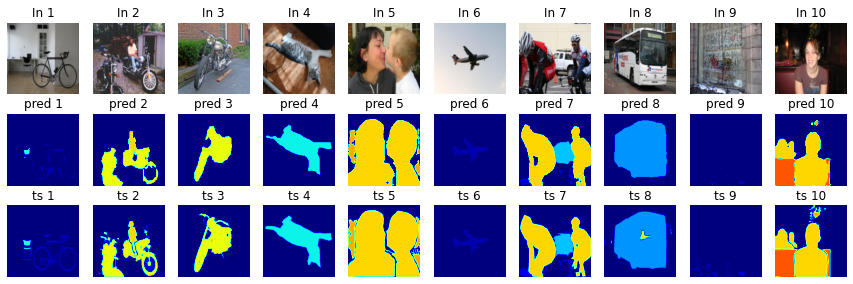

Iter:6050, Loss:0.1511, Accuracy:0.9572
Iter:6100, Loss:0.2393, Accuracy:0.9338
Iter:6150, Loss:0.1780, Accuracy:0.9491
Iter:6200, Loss:0.2284, Accuracy:0.9382
Iter:6250, Loss:0.2138, Accuracy:0.9430
Iter:6300, Loss:0.1078, Accuracy:0.9695
Iter:6350, Loss:0.1761, Accuracy:0.9512
Iter:6400, Loss:0.1259, Accuracy:0.9644
Iter:6450, Loss:0.1939, Accuracy:0.9471
Iter:6500, Loss:0.1223, Accuracy:0.9647
result was saved to >> result/UNet_result_iter6500.jpg


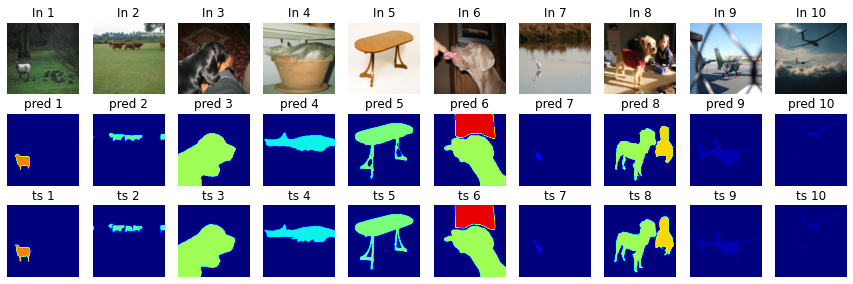

Iter:6550, Loss:0.1825, Accuracy:0.9499
Iter:6600, Loss:0.1994, Accuracy:0.9459
Iter:6650, Loss:0.2335, Accuracy:0.9357
Iter:6700, Loss:0.1787, Accuracy:0.9501
Iter:6750, Loss:0.2150, Accuracy:0.9436
Iter:6800, Loss:0.1824, Accuracy:0.9492
Iter:6850, Loss:0.1411, Accuracy:0.9615
Iter:6900, Loss:0.1354, Accuracy:0.9631
Iter:6950, Loss:0.1239, Accuracy:0.9661
Iter:7000, Loss:0.1954, Accuracy:0.9462
save  >> models/UNet_iter7000.pt
result was saved to >> result/UNet_result_iter7000.jpg


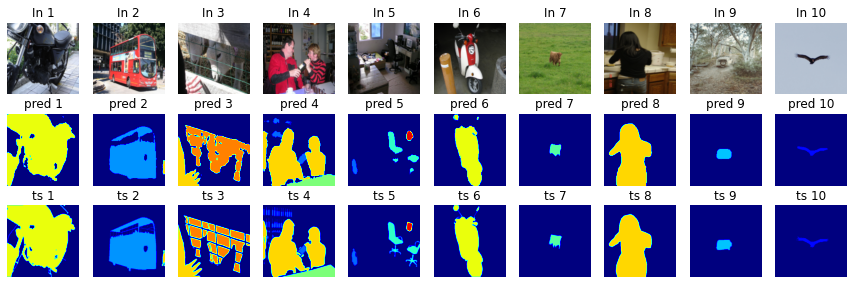

Iter:7050, Loss:0.1396, Accuracy:0.9604
Iter:7100, Loss:0.1584, Accuracy:0.9544
Iter:7150, Loss:0.1349, Accuracy:0.9611
Iter:7200, Loss:0.2000, Accuracy:0.9450
Iter:7250, Loss:0.1535, Accuracy:0.9564
Iter:7300, Loss:0.1299, Accuracy:0.9640
Iter:7350, Loss:0.1406, Accuracy:0.9596
Iter:7400, Loss:0.1783, Accuracy:0.9496
Iter:7450, Loss:0.1531, Accuracy:0.9568
Iter:7500, Loss:0.2085, Accuracy:0.9389
result was saved to >> result/UNet_result_iter7500.jpg


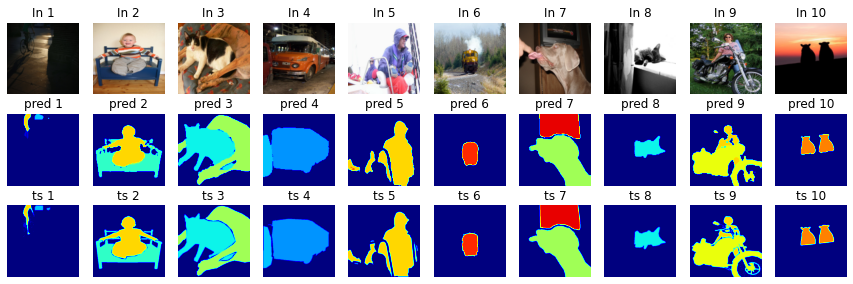

Iter:7550, Loss:0.1868, Accuracy:0.9483
Iter:7600, Loss:0.1323, Accuracy:0.9627
Iter:7650, Loss:0.1526, Accuracy:0.9554
Iter:7700, Loss:0.2153, Accuracy:0.9410
Iter:7750, Loss:0.1631, Accuracy:0.9554
Iter:7800, Loss:0.1190, Accuracy:0.9664
Iter:7850, Loss:0.2158, Accuracy:0.9402
Iter:7900, Loss:0.1370, Accuracy:0.9609
Iter:7950, Loss:0.1536, Accuracy:0.9580
Iter:8000, Loss:0.1427, Accuracy:0.9612
save  >> models/UNet_iter8000.pt
result was saved to >> result/UNet_result_iter8000.jpg


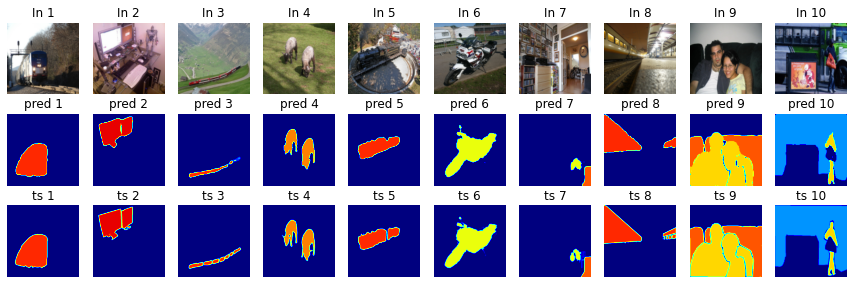

Iter:8050, Loss:0.1648, Accuracy:0.9558
Iter:8100, Loss:0.1358, Accuracy:0.9596
Iter:8150, Loss:0.1172, Accuracy:0.9659
Iter:8200, Loss:0.1307, Accuracy:0.9610
Iter:8250, Loss:0.1372, Accuracy:0.9612
Iter:8300, Loss:0.1286, Accuracy:0.9637
Iter:8350, Loss:0.1754, Accuracy:0.9486
Iter:8400, Loss:0.1197, Accuracy:0.9639
Iter:8450, Loss:0.1161, Accuracy:0.9652
Iter:8500, Loss:0.1315, Accuracy:0.9618
result was saved to >> result/UNet_result_iter8500.jpg


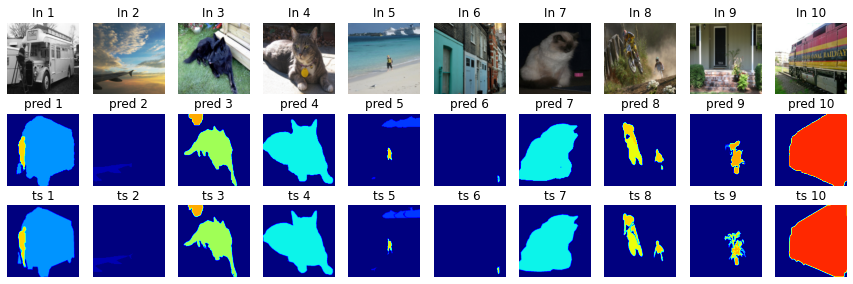

Iter:8550, Loss:0.1526, Accuracy:0.9545
Iter:8600, Loss:0.1186, Accuracy:0.9649
Iter:8650, Loss:0.1765, Accuracy:0.9499
Iter:8700, Loss:0.1525, Accuracy:0.9548
Iter:8750, Loss:0.2132, Accuracy:0.9411
Iter:8800, Loss:0.1617, Accuracy:0.9531
Iter:8850, Loss:0.1572, Accuracy:0.9535
Iter:8900, Loss:0.1846, Accuracy:0.9452
Iter:8950, Loss:0.1090, Accuracy:0.9667
Iter:9000, Loss:0.1536, Accuracy:0.9554
save  >> models/UNet_iter9000.pt
result was saved to >> result/UNet_result_iter9000.jpg


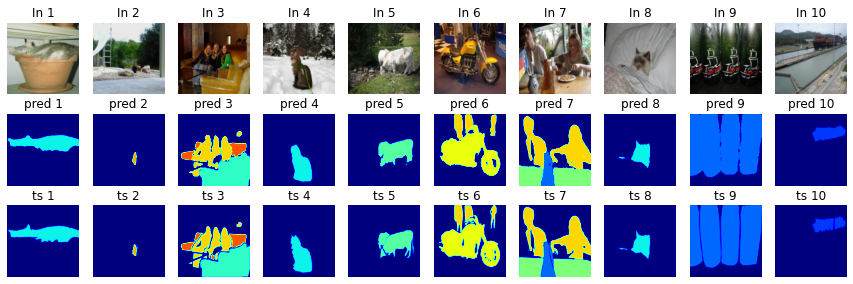

Iter:9050, Loss:0.1549, Accuracy:0.9555
Iter:9100, Loss:0.1957, Accuracy:0.9417
Iter:9150, Loss:0.1306, Accuracy:0.9613
Iter:9200, Loss:0.1553, Accuracy:0.9556
Iter:9250, Loss:0.1509, Accuracy:0.9535
Iter:9300, Loss:0.1445, Accuracy:0.9558
Iter:9350, Loss:0.1304, Accuracy:0.9607
Iter:9400, Loss:0.1119, Accuracy:0.9674
Iter:9450, Loss:0.1386, Accuracy:0.9578
Iter:9500, Loss:0.1598, Accuracy:0.9511
result was saved to >> result/UNet_result_iter9500.jpg


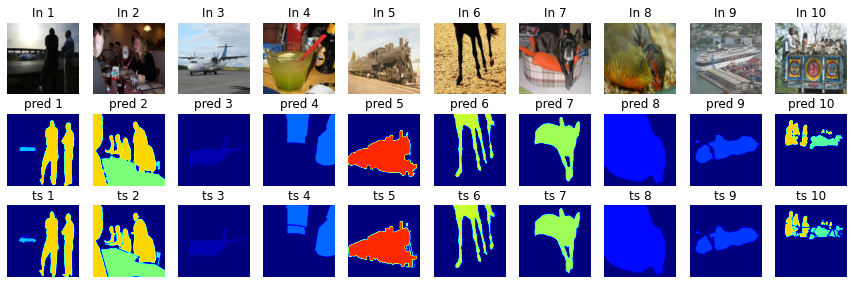

Iter:9550, Loss:0.1085, Accuracy:0.9661
Iter:9600, Loss:0.1218, Accuracy:0.9633
Iter:9650, Loss:0.1445, Accuracy:0.9571
Iter:9700, Loss:0.1197, Accuracy:0.9634
Iter:9750, Loss:0.1260, Accuracy:0.9633
Iter:9800, Loss:0.1340, Accuracy:0.9580
Iter:9850, Loss:0.1348, Accuracy:0.9598
Iter:9900, Loss:0.1429, Accuracy:0.9560
Iter:9950, Loss:0.1321, Accuracy:0.9600
Iter:10000, Loss:0.1210, Accuracy:0.9639
save  >> models/UNet_iter10000.pt
result was saved to >> result/UNet_result_iter10000.jpg


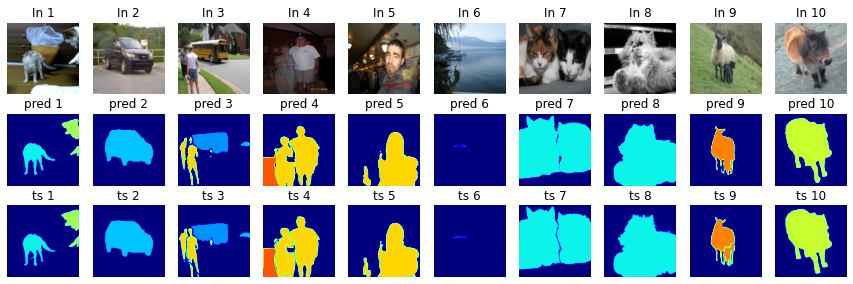

final paramters were saved to >> models/UNet_final.pt
loss was saved to >> result/UNet_loss.txt


In [0]:
# train
def train():
    # model
    model = UNet().to(cfg.DEVICE)
    summary(model, (cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH), device=cfg.DEVICE_TYPE)

    model.train()

    opt = cfg.TRAIN.OPTIMIZER(model.parameters(), **cfg.TRAIN.LEARNING_PARAMS)

    # path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    # paths = path_dict['paths']
    # paths_gt = path_dict['paths_gt']

    ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='train', download=True, 
                                          transform=transform, target_transform=target_transform)

    data_num = len(ds)
    print('train data =', data_num)
    
    # training
    batch_gen = BatchGenerator(data_num, cfg.TRAIN.MINIBATCH)

    list_iter = []
    list_loss = []
    list_accuracy = []

    ones = torch.zeros([cfg.TRAIN.MINIBATCH, 1], dtype=torch.float).to(cfg.DEVICE)
    zeros = ones * 0
    
    loss_l1 = torch.nn.CrossEntropyLoss()

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        mb_inds = batch_gen()
        # sample X
        Xs = torch.cat([ds[xi][0].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
        ts = torch.cat([ds[xi][1].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
        # Xs = Xs_data[mb_inds].to(cfg.DEVICE)
        # ts = ts_data[mb_inds].to(cfg.DEVICE)

        # update G
        opt.zero_grad()

        ys = model(Xs)

        # reshape output and ts for loss
        _ys = ys.reshape(ys.size()[0], ys.size()[1], -1)
        _ts = ts.reshape(ts.size()[0], -1)

        loss = loss_l1(_ys, _ts) # L1 loss
        loss.backward()
        opt.step()

        preds = _ys.argmax(dim=1)
        accuracy = (preds == _ts).sum() / float(cfg.TRAIN.MINIBATCH * cfg.OUTPUT_HEIGHT * cfg.OUTPUT_WIDTH)


        progres_bar += '|'

        _loss = loss.item()
        _accuracy = accuracy.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss.append(_loss)
                list_accuracy.append(_accuracy)

        print('\r' + 'Loss:{:.4f}, Accu:{:.4f} '.format(_loss, _accuracy) + progres_bar, end='')
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, Loss:{:.4f}, Accuracy:{:.4f}'.format(i + 1, _loss, _accuracy))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(model.state_dict(), save_path)
            print('save  >> {}'.format(save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                Xs, ys.argmax(dim=1), ts, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

    save_path = cfg.TRAIN.MODEL_SAVE_PATH.format('final')
    torch.save(model.state_dict(), save_path)
    print('final paramters were saved to >> {}'.format(save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss' : list_loss, 'accuracy' : list_accuracy})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## plot Loss, Accuracy

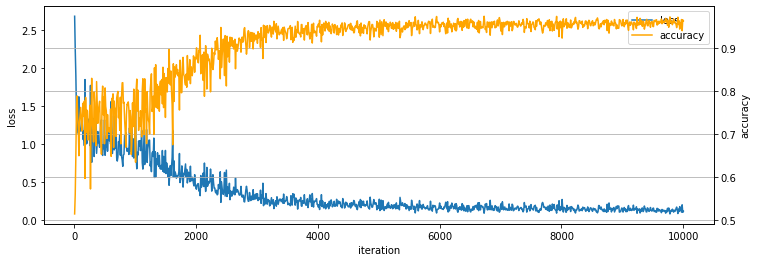

In [0]:
def plot_process():
    df = pd.read_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax2 = ax.twinx()
    lns1 = ax.plot(df['iteration'], df['loss'], label='loss')
    lns2 = ax2.plot(df['iteration'], df['accuracy'], color='orange', label='accuracy')

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.set_ylabel('loss')
    ax.set_xlabel('iteration')
    ax2.set_ylabel('accuracy')
    plt.grid()
    plt.show()

plot_process()

## Test

--------------------
test function
--------------------
Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar
data = 1449


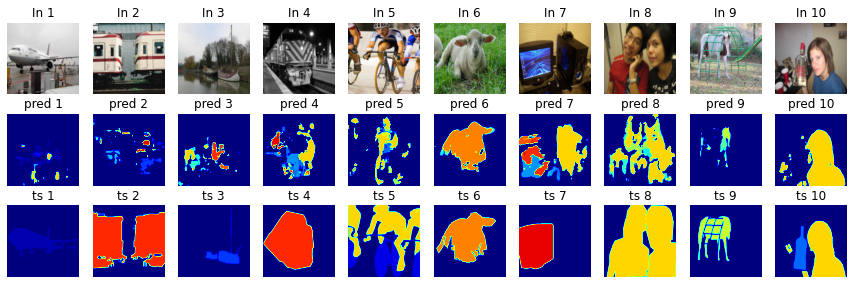

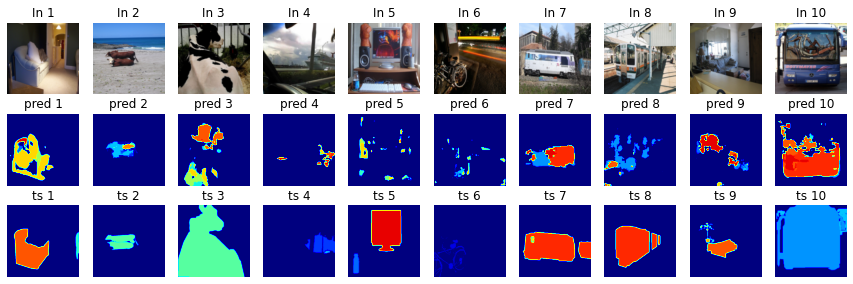

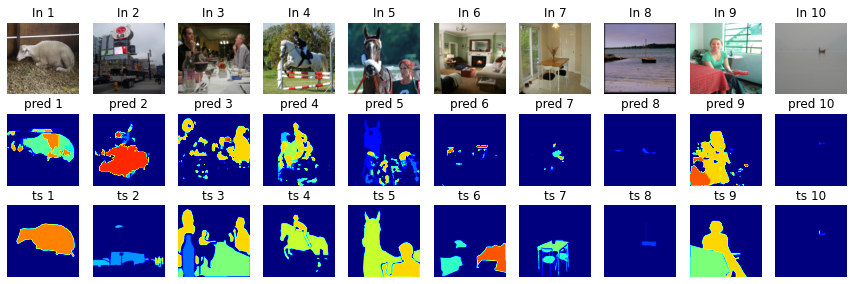

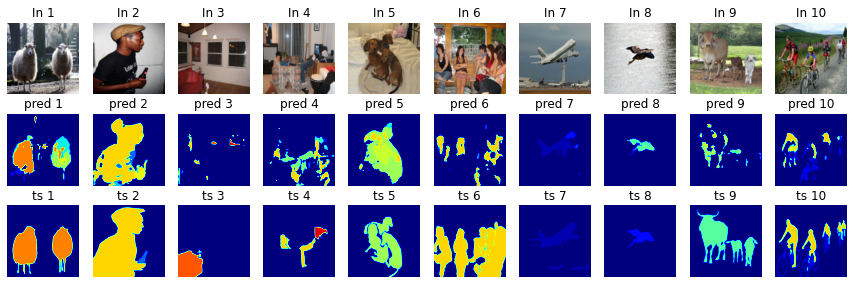

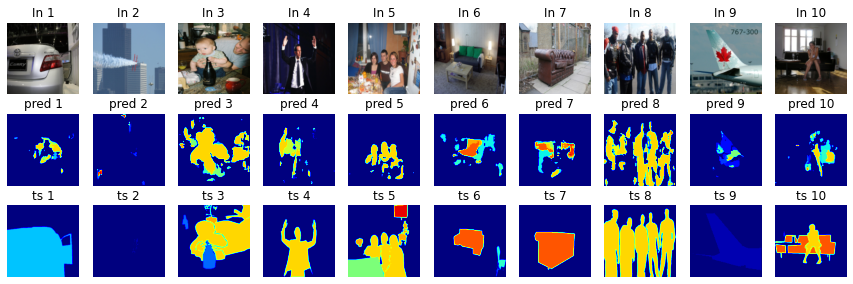

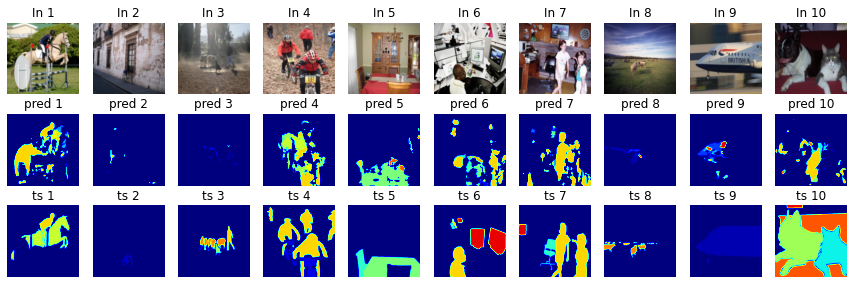

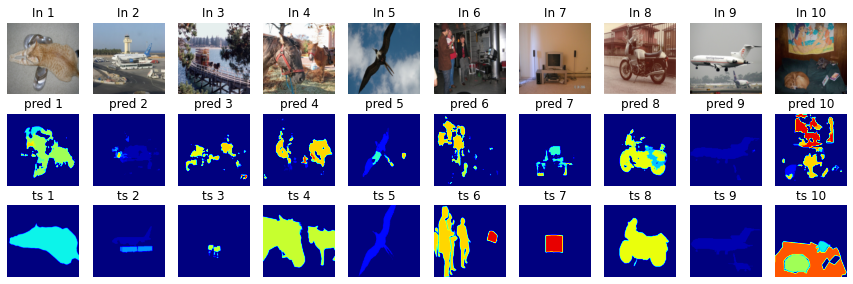

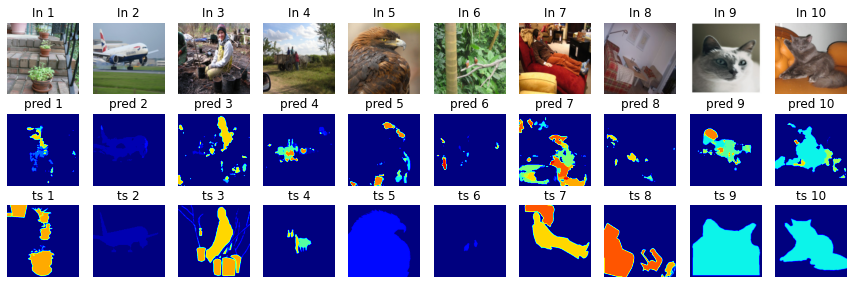

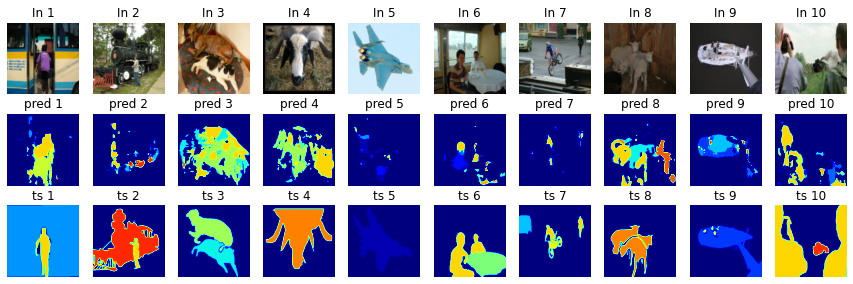

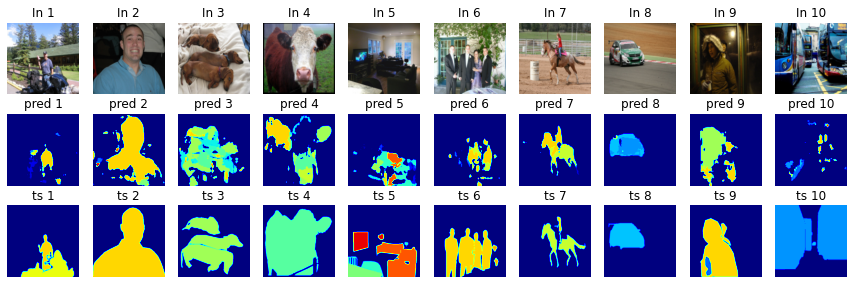

In [0]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    model = UNet().to(cfg.DEVICE)
    model.load_state_dict(torch.load(cfg.TEST.MODEL_PATH, map_location=torch.device(cfg.DEVICE)))
    model.eval()

    ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='val', download=True, 
                                          transform=transform, target_transform=target_transform)

    data_num = len(ds)
    print('data =', data_num)

    max_num = min(data_num, cfg.TEST.MAX_SAMPLES) if cfg.TEST.MAX_SAMPLES is not None else data_num

    with torch.no_grad():
        for i in range(0, max_num, cfg.TEST.MINIBATCH):
            mb_inds = np.arange(i, min(i + cfg.TEST.MINIBATCH, max_num))
            
            Xs = torch.cat([ds[xi][0].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
            ts = torch.cat([ds[xi][1].unsqueeze(0) for xi in mb_inds]).to(cfg.DEVICE)
           
            ys = model(Xs) 

            result_show(Xs, ys.argmax(dim=1), ts, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)
test()

## VOC Data load sample

In [0]:
transform = transforms.Compose([
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    transforms.ToTensor(),
])

ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='train', download=True, 
                                          transform=transform, target_transform=None)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar


In [0]:
Xs_data, ts_data = ds[0]

In [0]:
Xs_data

tensor([[[0.5216, 0.5255, 0.5373,  ..., 0.7294, 0.7216, 0.7176],
         [0.5255, 0.5294, 0.5373,  ..., 0.7333, 0.7255, 0.7216],
         [0.5294, 0.5333, 0.5412,  ..., 0.7333, 0.7294, 0.7255],
         ...,
         [0.0353, 0.0510, 0.0431,  ..., 0.0902, 0.0863, 0.0863],
         [0.0353, 0.0471, 0.0392,  ..., 0.0588, 0.0510, 0.0549],
         [0.0314, 0.0431, 0.0392,  ..., 0.0549, 0.0588, 0.0588]],

        [[0.7647, 0.7725, 0.7843,  ..., 0.9255, 0.9176, 0.9137],
         [0.7686, 0.7765, 0.7843,  ..., 0.9294, 0.9216, 0.9176],
         [0.7725, 0.7804, 0.7882,  ..., 0.9294, 0.9255, 0.9176],
         ...,
         [0.0471, 0.0627, 0.0706,  ..., 0.1725, 0.1686, 0.1686],
         [0.0588, 0.0627, 0.0706,  ..., 0.1333, 0.1255, 0.1255],
         [0.0627, 0.0588, 0.0706,  ..., 0.1294, 0.1333, 0.1294]],

        [[0.8235, 0.8314, 0.8431,  ..., 0.9529, 0.9490, 0.9490],
         [0.8275, 0.8353, 0.8431,  ..., 0.9569, 0.9490, 0.9490],
         [0.8314, 0.8392, 0.8471,  ..., 0.9569, 0.9490, 0.

In [0]:
Xs_data.size()

torch.Size([3, 128, 128])

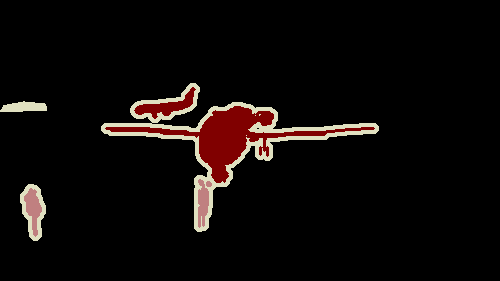

In [0]:
ts_data

In [0]:
_ts = np.array(ts_data.convert('P'))

In [0]:
_ts.shape

(281, 500)

In [0]:
_ts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
_ts[_ts != 0]

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [0]:
np.unique(_ts, return_counts=True)

(array([  0,   1,  15, 255], dtype=uint8),
 array([129545,   4734,    866,   5355]))

In [0]:
_ts[_ts == 255] = 0

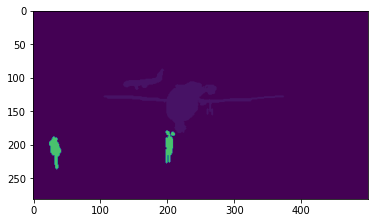

In [0]:
plt.imshow(_ts, vmax=21)

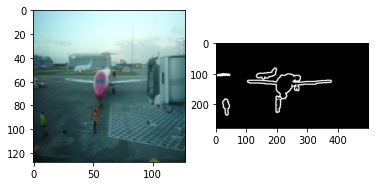

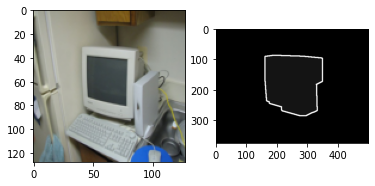

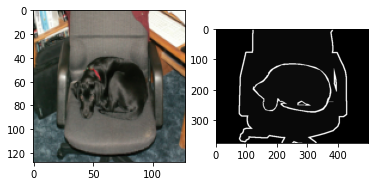

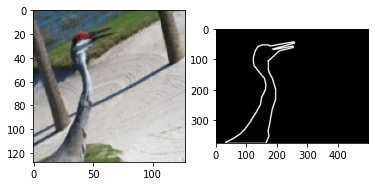

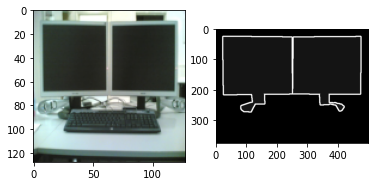

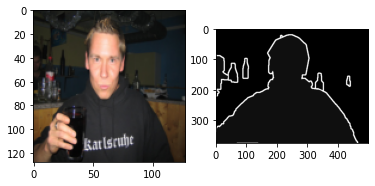

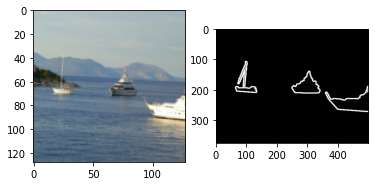

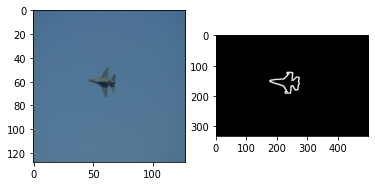

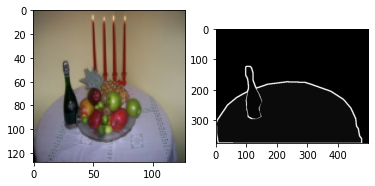

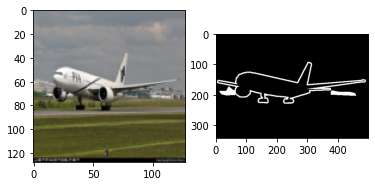

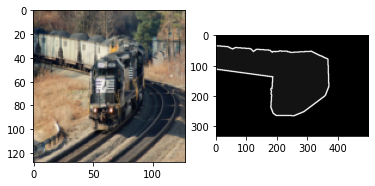

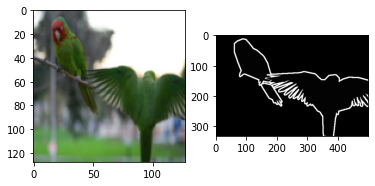

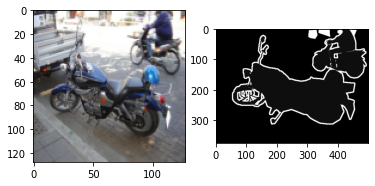

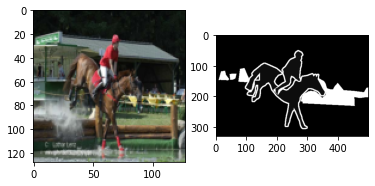

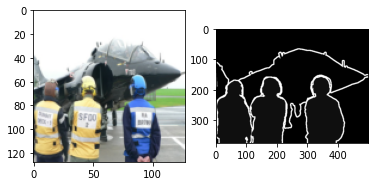

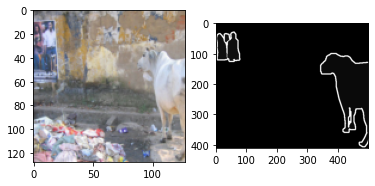

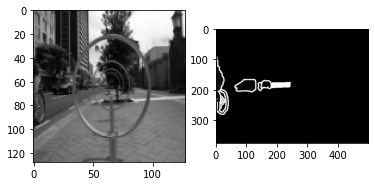

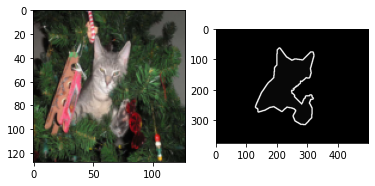

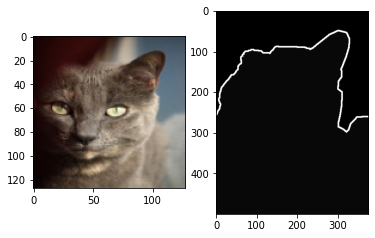

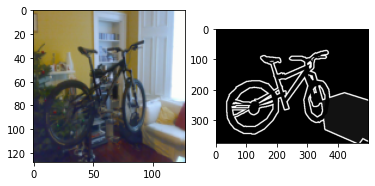

In [0]:
for i in range(20):
    Xs, ts = ds[i]
    plt.subplot(1, 2, 1)
    plt.imshow(Xs.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(np.array(ts.convert('P')), cmap='gray')
    plt.show()

### try my transform

In [0]:
from PIL import Image

class Seg2Index(object):
    def __init__(self, border=False):
        self.border = border # contain border

    def __call__(self, x):
        x = np.array(x.convert('P')) # convert image > index
        if not self.border:
            x[x == 255] = 0
        return Image.fromarray(x)

    def __repr__(self):
        return self.__class__.__name__ + '()'

class ToTensorKeepValue(object):
    def __call__(self, x):
        return torch.tensor(np.array(x))

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [0]:
transform = transforms.Compose([
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    Seg2Index(),
    transforms.Resize((cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH)),
    ToTensorKeepValue()
])

ds = torchvision.datasets.VOCSegmentation(root=cfg.TRAIN.DATA_PATH, image_set='train', download=True, 
                                          transform=transform, target_transform=target_transform)

Using downloaded and verified file: data/VOCtrainval_11-May-2012.tar


torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


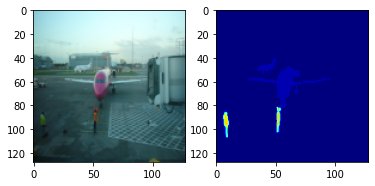

torch.Size([128, 128]) tensor(20, dtype=torch.uint8)


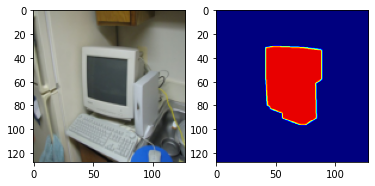

torch.Size([128, 128]) tensor(12, dtype=torch.uint8)


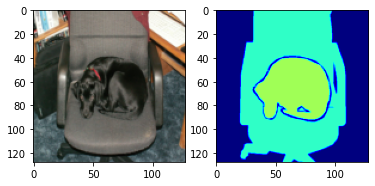

torch.Size([128, 128]) tensor(3, dtype=torch.uint8)


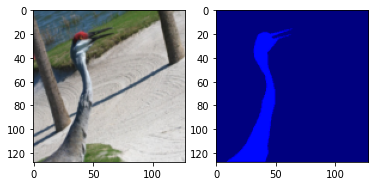

torch.Size([128, 128]) tensor(20, dtype=torch.uint8)


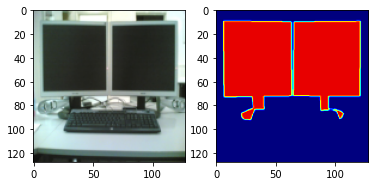

torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


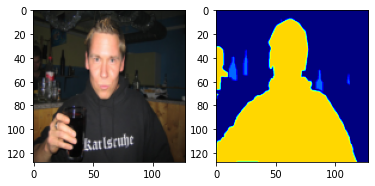

torch.Size([128, 128]) tensor(4, dtype=torch.uint8)


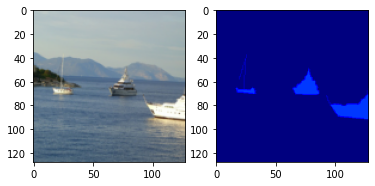

torch.Size([128, 128]) tensor(1, dtype=torch.uint8)


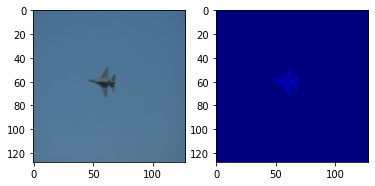

torch.Size([128, 128]) tensor(11, dtype=torch.uint8)


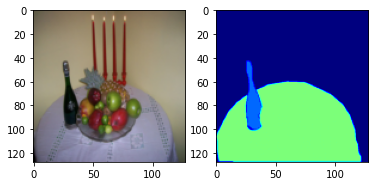

torch.Size([128, 128]) tensor(1, dtype=torch.uint8)


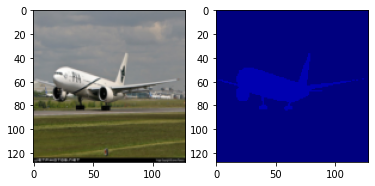

torch.Size([128, 128]) tensor(19, dtype=torch.uint8)


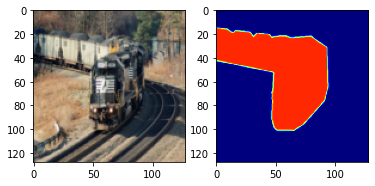

torch.Size([128, 128]) tensor(3, dtype=torch.uint8)


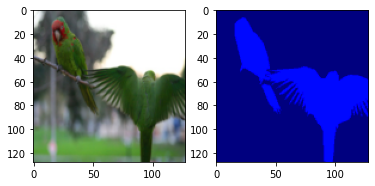

torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


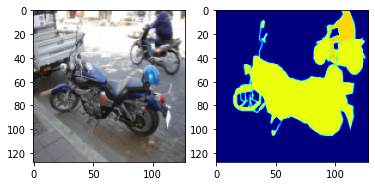

torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


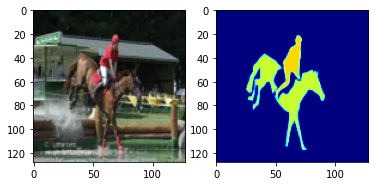

torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


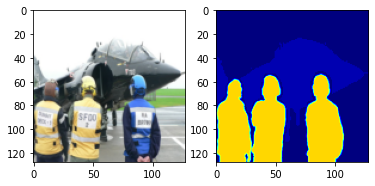

torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


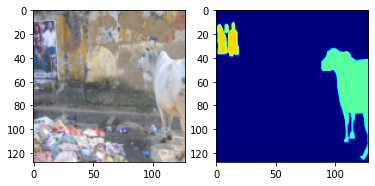

torch.Size([128, 128]) tensor(15, dtype=torch.uint8)


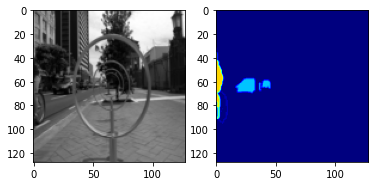

torch.Size([128, 128]) tensor(8, dtype=torch.uint8)


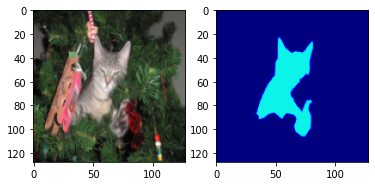

torch.Size([128, 128]) tensor(8, dtype=torch.uint8)


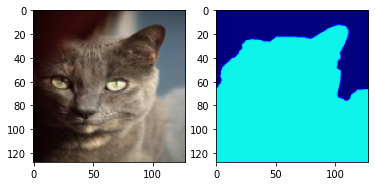

torch.Size([128, 128]) tensor(18, dtype=torch.uint8)


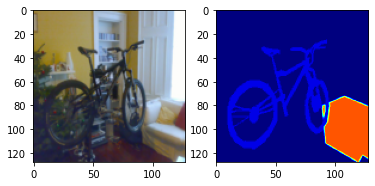

In [0]:
for i in range(20):
    Xs, ts = ds[i]
    plt.subplot(1, 2, 1)
    plt.imshow(Xs.permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(ts, vmax=22, cmap='jet')
    print(ts.size(), ts.max())
    plt.show()

In [0]:
ds

Dataset VOCSegmentation
    Number of datapoints: 1464
    Root location: data/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Target transform: Compose(
                      Seg2Index()
                      Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                      ToTensorKeepValue()
                  )

In [0]:
len(ds)

1464

In [0]:
torch.cat([ds[xi][0].unsqueeze(0) for xi in [0,3,4]]).to(cfg.DEVICE).size()

torch.Size([3, 3, 128, 128])

In [0]:
[ds[xi][0] for xi in [0,3,4]]

[tensor([[[0.5216, 0.5255, 0.5373,  ..., 0.7294, 0.7216, 0.7176],
          [0.5255, 0.5294, 0.5373,  ..., 0.7333, 0.7255, 0.7216],
          [0.5294, 0.5333, 0.5412,  ..., 0.7333, 0.7294, 0.7255],
          ...,
          [0.0353, 0.0510, 0.0431,  ..., 0.0902, 0.0863, 0.0863],
          [0.0353, 0.0471, 0.0392,  ..., 0.0588, 0.0510, 0.0549],
          [0.0314, 0.0431, 0.0392,  ..., 0.0549, 0.0588, 0.0588]],
 
         [[0.7647, 0.7725, 0.7843,  ..., 0.9255, 0.9176, 0.9137],
          [0.7686, 0.7765, 0.7843,  ..., 0.9294, 0.9216, 0.9176],
          [0.7725, 0.7804, 0.7882,  ..., 0.9294, 0.9255, 0.9176],
          ...,
          [0.0471, 0.0627, 0.0706,  ..., 0.1725, 0.1686, 0.1686],
          [0.0588, 0.0627, 0.0706,  ..., 0.1333, 0.1255, 0.1255],
          [0.0627, 0.0588, 0.0706,  ..., 0.1294, 0.1333, 0.1294]],
 
         [[0.8235, 0.8314, 0.8431,  ..., 0.9529, 0.9490, 0.9490],
          [0.8275, 0.8353, 0.8431,  ..., 0.9569, 0.9490, 0.9490],
          [0.8314, 0.8392, 0.8471,  ...,